# Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Macroeconomic and Financial Market features

In [2]:
macro_and_market_features_ = ['CPIAUCNS yoy ', 'CSUSHPISA yoy', 'INDPRO ', 'IQ yoy', 'IR yoy',
       'MICH', 'PPIACO yoy', 'PSAVERT', 'Mean (USD-GBP)',
       'Standard dev. (USD-GBP)', 'Kurtosis (USD-GBP)', 'Skew (USD-GBP)',
       '25th percentile (USD-GBP)', '75th percentile (USD-GBP)',
       'Mean (3M T-Bill)', 'Standard dev. (3M T-Bill)', 'Kurtosis (3M T-Bill)',
       'Skew (3M T-Bill)', '25th percentile (3M T-Bill)',
       '75th percentile (3M T-Bill)', 'Mean (DGS2)', 'Standard dev. (DGS2)',
       'Kurtosis (DGS2)', 'Skew (DGS2)', '25th percentile (DGS2)',
       '75th percentile (DGS2)', 'Mean (DGS5)', 'Standard dev. (DGS5)',
       'Kurtosis (DGS5)', 'Skew (DGS5)', '25th percentile (DGS5)',
       '75th percentile (DGS5)', 'Mean (DGS10)', 'Standard dev. (DGS10)',
       'Kurtosis (DGS10)', 'Skew (DGS10)', '25th percentile (DGS10)',
       '75th percentile (DGS10)', 'Mean (TEDRATE)', 'Standard dev. (TEDRATE)',
       'Kurtosis (TEDRATE)', 'Skew (TEDRATE)', '25th percentile (TEDRATE)',
       '75th percentile (TEDRATE)', 'Mean (T10Y3M)', 'Standard dev. (T10Y3M)',
       'Kurtosis (T10Y3M)', 'Skew (T10Y3M)', '25th percentile (T10Y3M)',
       '75th percentile (T10Y3M)', 'Mean (Crude Oil)',
       'Standard dev. (Crude Oil)', 'Kurtosis (Crude Oil)', 'Skew (Crude Oil)',
       '25th percentile (Crude Oil)', '75th percentile (Crude Oil)']

for feature, i in zip(macro_and_market_features_, range(1, len(macro_and_market_features_)+1)):
    print(f"Feature {i}: {feature}")

Feature 1: CPIAUCNS yoy 
Feature 2: CSUSHPISA yoy
Feature 3: INDPRO 
Feature 4: IQ yoy
Feature 5: IR yoy
Feature 6: MICH
Feature 7: PPIACO yoy
Feature 8: PSAVERT
Feature 9: Mean (USD-GBP)
Feature 10: Standard dev. (USD-GBP)
Feature 11: Kurtosis (USD-GBP)
Feature 12: Skew (USD-GBP)
Feature 13: 25th percentile (USD-GBP)
Feature 14: 75th percentile (USD-GBP)
Feature 15: Mean (3M T-Bill)
Feature 16: Standard dev. (3M T-Bill)
Feature 17: Kurtosis (3M T-Bill)
Feature 18: Skew (3M T-Bill)
Feature 19: 25th percentile (3M T-Bill)
Feature 20: 75th percentile (3M T-Bill)
Feature 21: Mean (DGS2)
Feature 22: Standard dev. (DGS2)
Feature 23: Kurtosis (DGS2)
Feature 24: Skew (DGS2)
Feature 25: 25th percentile (DGS2)
Feature 26: 75th percentile (DGS2)
Feature 27: Mean (DGS5)
Feature 28: Standard dev. (DGS5)
Feature 29: Kurtosis (DGS5)
Feature 30: Skew (DGS5)
Feature 31: 25th percentile (DGS5)
Feature 32: 75th percentile (DGS5)
Feature 33: Mean (DGS10)
Feature 34: Standard dev. (DGS10)
Feature 35: Kurt

# Combine target and features into one dataframe

In [3]:
# Monthly series
df1 = pd.read_csv("files/Monthly stationary series.csv")
# Extracted features
df2 = pd.read_csv("files/Monthly Extracted Features.csv")
# Merge data
features = pd.concat([df1, df2], axis=1)

# Add date columns to list with feature names
macro_and_market_features_.insert(0, 'DATE')
features = features[macro_and_market_features_]

# Extract date column and Bond/Stock features
features = features.drop(0)                       # Drop first row
features = features.drop(features.index[-1])      # Drop last row
features = features.reset_index(drop=True)

# Target
target = pd.read_csv("files/Target.csv")
complete_set = pd.concat([target, features], axis=1)
complete_set.columns.array[3]= "DATE Features"
print(complete_set.iloc[:, 0:5])


'''
There are two columns with dates, as one functions for the target (see column 0: DATE) at time t+1, and the other (see column 4: DATE Features) for the feature date at time t.
'''

           DATE  Stock index  Bond Index DATE Features  CPIAUCNS yoy 
0    01/03/1990         0.70        0.30    01/02/1990          0.100
1    01/04/1990         0.98        0.02    01/03/1990          0.000
2    01/05/1990         0.30        0.70    01/04/1990         -0.600
3    01/06/1990         0.00        1.00    01/05/1990         -0.400
4    01/07/1990         0.00        1.00    01/06/1990          0.400
..          ...          ...         ...           ...            ...
377  01/08/2021         0.99        0.01    01/07/2021          0.003
378  01/09/2021         0.00        1.00    01/08/2021         -0.253
379  01/10/2021         0.65        0.35    01/09/2021          0.381
380  01/11/2021         0.00        1.00    01/10/2021          2.171
381  01/12/2021         0.67        0.33    01/11/2021          1.518

[382 rows x 5 columns]


'\nThere are two columns with dates, as one functions for the target (see column 0: DATE) at time t+1, and the other (see column 4: DATE Features) for the feature date at time t.\n'

# Standardize features

In [5]:
df = complete_set

# Separate the years, target columns, and features
years = df.iloc[:, 3]
target_columns = df.iloc[:, 1:3]
features = df.iloc[:, 4:]

# Identify the indices corresponding to the training and test periods
train_indices = (pd.to_datetime(years, format='%d/%m/%Y') >= '1990-01-01') & (pd.to_datetime(years, format='%d/%m/%Y') <= '2010-12-31')
valid_and_test_indices = (pd.to_datetime(years, format='%d/%m/%Y') >= '2011-01-01') & (pd.to_datetime(years, format='%d/%m/%Y') <= '2021-12-31')

# Extract the training and test features
X_train = features[train_indices]
X_valid_and_test = features[valid_and_test_indices]

# Calculate mean and standard deviation using only the training data
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# Standardize the training and test features using the training statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_and_test_scaled = scaler.transform(X_valid_and_test)

# Replace the original feature columns with the standardized ones
df.iloc[train_indices, 4:] = X_train_scaled
df.iloc[valid_and_test_indices, 4:] = X_valid_and_test_scaled
print(f"Shape: {df.shape}\n")
print(df.iloc[:, :5])
df.to_csv("files/Standardized features Macro&Fin.Markets.csv")

Shape: (382, 60)

           DATE  Stock index  Bond Index DATE Features  CPIAUCNS yoy 
0    01/03/1990         0.70        0.30    01/02/1990       0.138627
1    01/04/1990         0.98        0.02    01/03/1990       0.015108
2    01/05/1990         0.30        0.70    01/04/1990      -0.726010
3    01/06/1990         0.00        1.00    01/05/1990      -0.478971
4    01/07/1990         0.00        1.00    01/06/1990       0.509186
..          ...          ...         ...           ...            ...
377  01/08/2021         0.99        0.01    01/07/2021       0.018813
378  01/09/2021         0.00        1.00    01/08/2021      -0.297397
379  01/10/2021         0.65        0.35    01/09/2021       0.485718
380  01/11/2021         0.00        1.00    01/10/2021       2.696720
381  01/12/2021         0.67        0.33    01/11/2021       1.890136

[382 rows x 5 columns]


# MLP: tune hyper-parameters for one window

- Each layer can have a unique number of neurons. 
- The dropout rate is the same in each hidden layer
- Batch normalization occurs after each hidden layer or does not occur at all


In [6]:
# Set the seed for reproducibility purposes
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def optimize_hyperparameters(X_train, y_train, X_val, y_val):
    def build_model(hp):
        model = Sequential()
        
        # Input layer & first hidden layer
        model.add(Dense(units=hp.Choice('N_neurons_layer_1', values=[8, 16, 32, 64, 128]), input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(hp.Choice('Dropout_rate', values=[0.0, 0.25, 0.5])))
        if hp.Choice('Batch_normalization', values=[True, False]):
            model.add(BatchNormalization())

        # Minimum of 2 and maximum of 3 hidden layers
        n_hidden_layers = hp.Choice('N_hidden_layers', values=[2, 3])
        
        # Layer 2
        if n_hidden_layers == 2:
            model.add(Dense(units=hp.Choice('N_neurons_layer_2', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())    
        else:
            # Layer 2
            model.add(Dense(units=hp.Choice('N_neurons_layer_2', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())
                                    
            # Layer 3
            model.add(Dense(units=hp.Choice('N_neurons_layer_3', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())

                
        # Output: weight_stock_index & weight_bond_index
        model.add(Dense(units=2, activation='softmax'))

        # Learning rates for Adam (default=0.001)
        lr = hp.Choice('Learning_rate', values=[0.01, 0.0001, 0.001])
        optimizer = keras.optimizers.Adam(learning_rate=lr)
   
        # Compile model
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
        return model
    
    tuner = kt.RandomSearch(
        build_model,
        objective=kt.Objective('val_mean_absolute_error', direction='min'),
        max_trials=100,
        seed=42,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite= True)
        
    tuner.search(x=X_train,
                 y=y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(X_val, y_val))
    
    # Get the best hyperparameters and the best trial
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    best_hyperparameters = best_trial.hyperparameters

    return best_hyperparameters.values

# MLP: call function for each window to extract tuned hyper-parameters

In [8]:
# Pre-define table for hyper-parameter results
hp_results = pd.DataFrame(
    {"Window":              [None, None, None, None, None, None],
     "N_hidden_layers":     [None, None, None, None, None, None],
     "N_neurons_layer_1":   [None, None, None, None, None, None],
     "N_neurons_layer_2":   [None, None, None, None, None, None],
     "N_neurons_layer_3":   [None, None, None, None, None, None],
     "Batch_normalization": [None, None, None, None, None, None],
     "Dropout_rate":        [None, None, None, None, None, None],
     "Learning_rate":       [None, None, None, None, None, None],
     "MAE":                 [None, None, None, None, None, None]
    })

# Date (column 1), target (column B & C), Sharpe ratio (Column D), & features (column E & onwards)
exclude_bottom = ['1990', '1991', '1992', '1993', '1994']
exclude_top = ['2016', '2017', '2018', '2019', '2020', '2021']
validation_years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

start_year_validation = 0
end_year_validation = 5
for window in range(6):

    # Getting training data
    exclude_1 = exclude_bottom[:window]
    exclude_2 = exclude_top[window:]
    exclude_concat = exclude_1 + exclude_2
    full_window = df[~df['DATE'].str.contains('|'.join(exclude_concat))]

    # Training + validation set
    val_years = validation_years[start_year_validation:end_year_validation]
    train_set = full_window[~full_window['DATE'].str.contains('|'.join(val_years))]
    X_train = train_set.iloc[:, 4:]
    y_train = train_set.iloc[:, [1, 2]]
    
    # Validation set
    val_set = full_window[full_window['DATE'].str.contains('|'.join(val_years))]
    X_val = val_set.iloc[:, 4:]
    y_val = val_set.iloc[:, [1, 2]]

    start_year_validation += 1
    end_year_validation += 1

    results_one_window = optimize_hyperparameters(X_train, y_train, X_val, y_val)
    
    #Allocate results to dataframe
    hp_results.at[window, "Window"] = window
    hp_results.at[window, "N_hidden_layers"] = results_one_window['N_hidden_layers']
    hp_results.at[window, "N_neurons_layer_1"] = results_one_window['N_neurons_layer_1'] 
    hp_results.at[window, "N_neurons_layer_2"] = results_one_window['N_neurons_layer_2'] 
    if results_one_window['N_hidden_layers'] == 3:
        hp_results.at[window, "N_neurons_layer_3"] = results_one_window['N_neurons_layer_3'] 
    else: 
        hp_results.at[window, "N_neurons_layer_3"] = None
    hp_results.at[window, "Batch_normalization"] = results_one_window['Batch_normalization'] 
    hp_results.at[window, "Dropout_rate"] = results_one_window['Dropout_rate'] 
    hp_results.at[window, "Learning_rate"] = results_one_window['Learning_rate']
    print(hp_results)
    
hp_results.to_csv("Final results/Hyper-parameter results/MLP Macro&Fin.Markets Features.csv")
print(hp_results)

Trial 100 Complete [00h 00m 03s]
val_mean_absolute_error: 0.3641510009765625

Best val_mean_absolute_error So Far: 0.3185679018497467
Total elapsed time: 00h 05m 38s
  Window N_hidden_layers N_neurons_layer_1 N_neurons_layer_2  \
0      0               2                64                32   
1      1               2                32                16   
2      2               2                32                32   
3      3               2                16                 8   
4      4               2               128                64   
5      5               2                32                 8   

  N_neurons_layer_3 Batch_normalization Dropout_rate Learning_rate   MAE  
0              None                   0         0.25         0.001  None  
1              None                   1          0.0         0.001  None  
2              None                   1          0.5         0.001  None  
3              None                   1          0.0        0.0001  None  
4         

# MLP: get results on test set for one window

In [6]:
def test_set(X_train, y_train, X_test, y_test, n_layers, n_neurons_L1, n_neurons_L2, n_neurons_L3, batch_normalization, dropout_rate, learning_rate):
    
    # Set the seed for reproducibility
    seed_value = 42
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(units=n_neurons_L1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))    
    if batch_normalization == True:
        model.add(BatchNormalization())
            
    if n_layers == 2:
        # Second hidden layer
        model.add(Dense(units=n_neurons_L2, activation='relu'))
        model.add(Dropout(dropout_rate))   
        if batch_normalization == True:
            model.add(BatchNormalization())
                  
        # Possible third hidden layer
        if n_layers == 3:
            model.add(Dense(units=n_neurons_L3, activation='relu'))
            model.add(Dropout(dropout_rate))    
            if batch_normalization == True:
                model.add(BatchNormalization())
        
    # Output: weight_stock_index & weight_bond_index
    model.add(Dense(units=2, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    loss, mae = model.evaluate(X_test, y_test)

    # R-squared
    r_squared = r2_score(y_test, y_pred)
    return mae, r_squared, y_test, y_pred

# MLP: call function for each window to extract all test results

Epoch 1/10
10/10 [==============================] - 1s 2ms/step - loss: 0.4108 - mae: 0.4108
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 0.3780 - mae: 0.3780
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3542 - mae: 0.3542
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3606 - mae: 0.3606
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3374 - mae: 0.3374
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3393 - mae: 0.3393
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3243 - mae: 0.3243
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3253 - mae: 0.3253
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3217 - mae: 0.3217
Epoch 10/10
1/1 [==============================] - 0s 194ms/step - loss: 0.4035 - mae: 0.4035


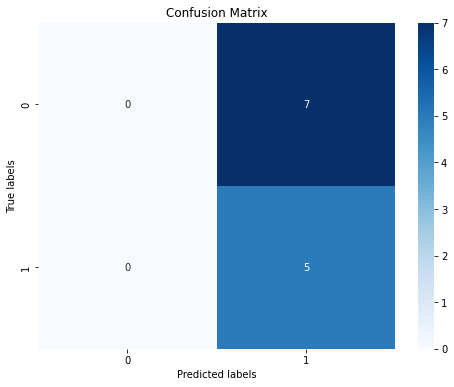

Epoch 1/10
10/10 [==============================] - 1s 8ms/step - loss: 0.4143 - mae: 0.4143
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3776 - mae: 0.3776
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3639 - mae: 0.3639
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3334 - mae: 0.3334
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3180 - mae: 0.3180
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3141 - mae: 0.3141
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3046 - mae: 0.3046
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3006 - mae: 0.3006
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2794 - mae: 0.2794
Epoch 10/10
1/1 [==============================] - 0s 143ms/step - loss: 0.2373 - mae: 0.2373


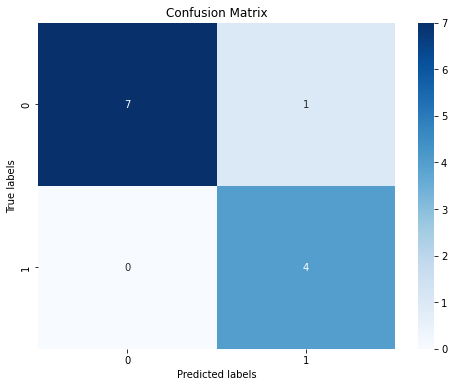

Epoch 1/10
10/10 [==============================] - 1s 9ms/step - loss: 0.4254 - mae: 0.4254
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3980 - mae: 0.3980
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3965 - mae: 0.3965
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4065 - mae: 0.4065
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.4109 - mae: 0.4109
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3947 - mae: 0.3947
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3930 - mae: 0.3930
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.4052 - mae: 0.4052
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3847 - mae: 0.3847
Epoch 10/10
1/1 [==============================] - 0s 141ms/step - loss: 0.5144 - mae: 0.5144


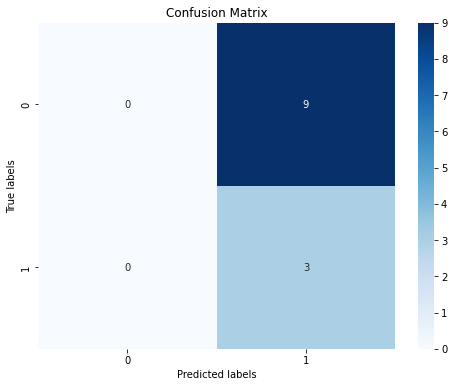

Epoch 1/10
10/10 [==============================] - 1s 1ms/step - loss: 0.3943 - mae: 0.3943
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3871 - mae: 0.3871
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3950 - mae: 0.3950
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3927 - mae: 0.3927
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3989 - mae: 0.3989
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3814 - mae: 0.3814
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3958 - mae: 0.3958
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3818 - mae: 0.3818
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3877 - mae: 0.3877
Epoch 10/10
1/1 [==============================] - 0s 198ms/step - loss: 0.3256 - mae: 0.3256


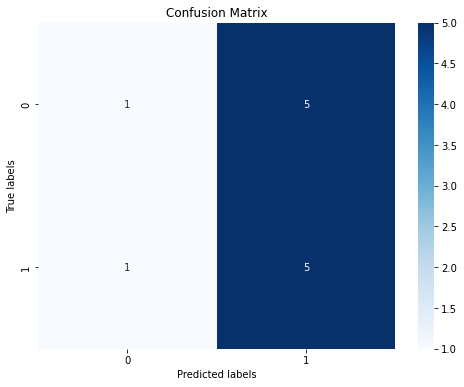

Epoch 1/10
10/10 [==============================] - 1s 9ms/step - loss: 0.4297 - mae: 0.4297
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3213 - mae: 0.3213
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.2986 - mae: 0.2986
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2554 - mae: 0.2554
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.2372 - mae: 0.2372
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2153 - mae: 0.2153
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2035 - mae: 0.2035
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.1933 - mae: 0.1933
Epoch 9/10
10/10 [==============================] - 0s 11ms/step - loss: 0.1869 - mae: 0.1869
Epoch 10/10
1/1 [==============================] - 0s 193ms/step - loss: 0.4816 - mae: 0.4816


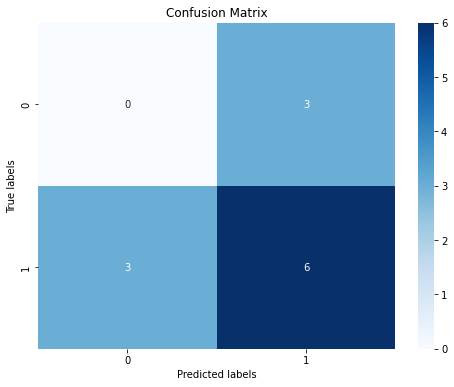

Epoch 1/10
10/10 [==============================] - 1s 8ms/step - loss: 0.3825 - mae: 0.3825
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3933 - mae: 0.3933
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3993 - mae: 0.3993
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3844 - mae: 0.3844
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3838 - mae: 0.3838
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.4007 - mae: 0.4007
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3940 - mae: 0.3940
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3937 - mae: 0.3937
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3978 - mae: 0.3978
Epoch 10/10
1/1 [==============================] - 0s 130ms/step - loss: 0.4393 - mae: 0.4393


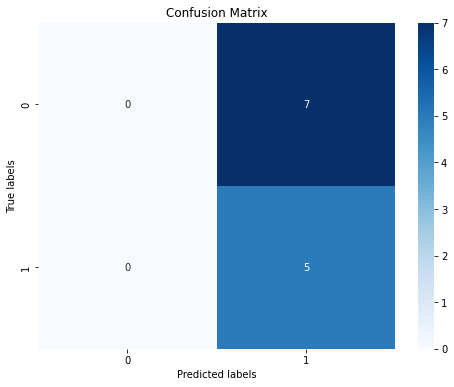

  Window    MAE R_squared Accuracy F1 Score
0      0  0.403    -0.643    0.417    0.245
1      1  0.237     0.047    0.917    0.919
2      2  0.514    -0.927     0.25      0.1
3      3  0.326     -0.32      0.5    0.438
4      4  0.482    -1.793      0.5      0.5
5      5  0.439    -0.554    0.417    0.245


In [7]:
# Import tuned hyper-paramters
hp_results = pd.read_csv("Final results/Hyper-parameter results/MLP Macro&Fin.Markets Features.csv")

# Years that will be removed from the data set (depending on the window)
bottom_years = ["1990", "1991", "1992", "1993","1994"]
test_years = ["2016", "2017", "2018", "2019", "2020", "2021"]

# Define table to store results
result_mlp = pd.DataFrame(
{"Window":              [None, None, None, None, None, None],
 "MAE":                 [None, None, None, None, None, None],
 "R_squared":           [None, None, None, None, None, None],
 "Accuracy":            [None, None, None, None, None, None],
 "F1 Score":            [None, None, None, None, None, None]
})

# Define np array to store actual and predicted weights
weights_results = pd.DataFrame([[None] * 5] * 72, columns=['Date', 'Actual Stock Weight', 'Actual Bond Weight', 'Predicted Stock Weight', 'Predicted Bond Weight'])

# Loop over each 
for window in range(6):
    # Retrieve hyper-parameters for window
    Window = hp_results.loc[window, ['Window']][0]
    N_hidden_layers = hp_results.loc[window, ['N_hidden_layers']][0]
    N_neurons_layer_1 = hp_results.loc[window, ['N_neurons_layer_1']][0]
    N_neurons_layer_2 = hp_results.loc[window, ['N_neurons_layer_2']][0]
    N_neurons_layer_3 = hp_results.loc[window, ['N_neurons_layer_3']][0]
    Batch_normalization = hp_results.loc[window, ['Batch_normalization']][0]
    Dropout_rate = hp_results.loc[window, ['Dropout_rate']][0]
    Learning_rate = hp_results.loc[window, ['Learning_rate']][0]

    # Exluce the bottom years in training set (depending on window)
    exclude_bottom_years = bottom_years[0:window]
    
    # Exclude test years in training set (depending on window)
    exclude_test_years = test_years[window:]
    
    # Merge years to exclude for training set (depending on window)
    train_exclude= exclude_bottom_years + exclude_test_years

    # Retrieve test year (depending on window)
    test_year = test_years[window]
   
    # Get filtered data set 
    whole_train = df[~df['DATE'].str.contains('|'.join(train_exclude))]
    whole_test = df[df['DATE'].str.contains(test_year)]

    # Select right columns
    X_train = whole_train.iloc[:, 4:]
    y_train = whole_train.iloc[:, [1, 2]]
    X_test = whole_test.iloc[:, 4:]
    y_test = whole_test.iloc[:, [1, 2]]

    # Extract results for each window
    result_window = test_set(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_layers=N_hidden_layers, n_neurons_L1=N_neurons_layer_1,n_neurons_L2=N_neurons_layer_2, n_neurons_L3=N_neurons_layer_3, batch_normalization=Batch_normalization, dropout_rate=Dropout_rate, learning_rate=Learning_rate)
    
    # Assign results to table
    result_mlp.at[window, "Window"] = window
    result_mlp.at[window, "MAE"] = np.round(result_window[0], 3)
    result_mlp.at[window, "R_squared"] = np.round(result_window[1], 3)

    # Assign results to table
    
    dates = list(whole_test.loc[:, "DATE"])
    weights_results.loc[window*12:(window*12+11), "Date"] = dates
    stock_optimal = list(whole_test.loc[:, "Stock index"])
    weights_results.loc[window*12:(window*12+11), "Actual Stock Weight"] = stock_optimal
    bond_optimal = list(whole_test.loc[:, "Bond Index"])
    weights_results.loc[window*12:(window*12+11), "Actual Bond Weight"] = bond_optimal
    pred_stock = list(result_window[3][:, 0])
    weights_results.loc[window*12:(window*12+11), "Predicted Stock Weight"] = pred_stock
    pred_bond = list(result_window[3][:, 1])
    weights_results.loc[window*12:(window*12+11), "Predicted Bond Weight"] = pred_bond
    
    # Rounc for classification results
    round_actual = np.round(result_window[2]).values #convert to np array
    round_pred = np.round(result_window[3])
    row_matches = np.all(round_pred == round_actual, axis=1)

    # Get accuracy and F1 score
    y_pred = (round_pred > 0.5)
    acc = accuracy_score(round_actual.argmax(axis=1), y_pred.argmax(axis=1))
    result_mlp.at[window, "Accuracy"] = round(acc, 3)
    f1 = f1_score(round_actual.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
    result_mlp.at[window, "F1 Score"] = round(f1, 3)
    	
    # Plot confusion matrix
    cm = confusion_matrix(round_actual.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
   
result_mlp.to_csv("Final results/Model results/MLP Macro&Fin.markets.csv")
weights_results.to_csv("Final results/Weight results/MLP Macro&Fin.markets.csv")
print(result_mlp)